In [1]:
import pandas as pd
import itertools
from sklearn.metrics import cohen_kappa_score
from scipy.stats import chi2_contingency
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

disagreement_type = "together"
def get_cohens_kappa(df,vis_columns,remove_multi=False):
    cohenskappa_results = []

    # Pairwise comparisons
    for col1, col2 in itertools.combinations(vis_columns, 2):
        sub_df = df.copy()
        if remove_multi:
            sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        kappa = cohen_kappa_score(sub_df[col1],sub_df[col2])
        cohenskappa_results.append({
            'Column 1': col1,
            'Column 2': col2,
            'Cohen\'s Kappa': kappa
        })
    cohenskappa_results_df = pd.DataFrame(cohenskappa_results)
    return cohenskappa_results_df



def get_chisquare(df, vis_columns):
    chi2_results = []

    for col1, col2 in itertools.combinations(vis_columns, 2):
        # Drop NA values to avoid errors
        sub_df = df[[col1, col2]].dropna()

        # Create contingency table
        contingency = pd.crosstab(sub_df[col1], sub_df[col2])

        # Run Chi-Square test
        chi2, p, _, _ = chi2_contingency(contingency)

        chi2_results.append({
            'Column 1': col1,
            'Column 2': col2,
            'Chi2 Stat': chi2,
            'p-value': p
        })

    chi2_df = pd.DataFrame(chi2_results)
    return chi2_df.sort_values("p-value")
 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrices_for_column_pairs(df, gt_col,vis_columns):

    n_pairs = len(vis_columns)

    # Determine layout: square-ish grid
    n_cols = int(np.ceil(np.sqrt(n_pairs)))
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    col1 = gt_col
    for idx, col2 in enumerate(vis_columns):
        ax = axes[idx]
        
        # Drop rows with missing values in either column
        sub_df = df[[col1, col2]].dropna().copy()
        start_length = len(sub_df)
        # sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        filter_length = len(sub_df)
        # Get confusion matrix
        labels = sorted(set(sub_df[col1]) | set(sub_df[col2]))
        cm = confusion_matrix(sub_df[col1], sub_df[col2], labels=labels)

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f"{col1} vs \n{col2}\n strt: {start_length}\nelim.:{filter_length-start_length}", fontsize=10)
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)

    # Hide any extra axes
    for j in range(len(vis_columns), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    return fig


Sleep
../exports/groundtruth/Annotated/Sleep_132_222_enriched.xlsx
Index(['UID', 'ROW_ID', 'Sent_ID', 'HADM_ID', 'CHARTTIME_dictionary',
       'STORETIME_dictionary', 'Sentence_dictionary', 'Event_Name_dictionary',
       'Keyword', 'Lemma', 'CGID_dictionary', 'Time_dictionary',
       'CHARTTIME_biolord', 'STORETIME_biolord', 'Sentence_biolord',
       'Event_Name_biolord', 'CGID_biolord', 'Similarity', 'Eating_similarity',
       'Excretion_similarity', 'Family_similarity', 'Pain_similarity',
       'Sleep_similarity', 'Time_biolord', 'Event_Name_dictionary_multi',
       'Event_Name_dictionary_bkp', 'Keyword_bkp', 'Lemma_bkp',
       'sampling_weight', 'is_keyword_present', 'gt_Sleep', 'good_example',
       'Comments'],
      dtype='object')
Keyword Stats:
is_keyword_present
False    222
True     132
Name: count, dtype: int64
After Grouping Sentences
is_keyword_present
False    221
True     131
Name: count, dtype: int64
After removing GT Unknown
is_keyword_present
False    221
Tru

{'f1': 0.9053497942386831,
 'acc': 0.9346590909090909,
 'prec': 0.8396946564885496,
 'rec': 0.9821428571428571}

*********All********
Number of True labels in y: 112
Number of False labels in y: 240
Train size: 281, Val size: 71
Train size: 281, Val size: 71
Train size: 282, Val size: 70
Train size: 282, Val size: 70
Train size: 282, Val size: 70


,threshold,f1,accuracy,precision,recall
0,0.402,0.714,0.831,0.750,0.682
1,0.399,0.606,0.817,0.714,0.526
2,0.440,0.667,0.814,0.812,0.565
3,0.504,0.385,0.771,0.833,0.250
4,0.504,0.474,0.714,0.900,0.321


Mean Metrics of K fold cross validation of Embedder


threshold   0.450
f1          0.569
accuracy    0.790
precision   0.802
recall      0.469
Name: mean, dtype: float64

{'positive': ['beginning of shift patient a&o. sleeping in naps', 'mobility: patient sat on side of bed..than was able to transfer to large wheelchair..however was unable to get self out of wheelchair this afternoon..patient was called and was able to get patient to stand and transfer to bed..has been sleeping rest of afternoon', "heart rate dropped to 50's when asleep, and diastolic blood pressure dropped to 80's -> a-paced at 70 then 80 bpm with sbp remaining in 80's -> neo re-started at 0.25mcg/kg-min with diastolic blood pressure rising to 90's", "resp--ls coarse/bronchial in bilat upper lobes, crackles 1/2 up bilat bases, no c/o sob, on ra sat down to 90%, o2 4l on w/sat up to 98% and down to 92-93% while sleeping, patient w/non prod, non congested cough, able to talk in full sentences w/out any c/o sob, rr 20-24, non labored, patient given 40mg iv lasix for crackles/decreased sat and decreased u/o w/lg diuresis, u/o has con't ~40cc/heart rate during noc", 'slept in long naps over

,threshold,f1,accuracy,precision,recall
0,0.093,0.909,0.841,0.854,0.972
1,0.074,0.949,0.909,0.925,0.974
2,0.095,0.919,0.860,0.895,0.944


Mean Metrics of K fold cross validation of Embedder


threshold   0.088
f1          0.926
accuracy    0.870
precision   0.891
recall      0.963
Name: mean, dtype: float64

*********Without Keyword********
Number of True labels in y: 2
Number of False labels in y: 219
Train size: 147, Val size: 74
Train size: 147, Val size: 74
Train size: 148, Val size: 73


/home/asusaiyah/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,threshold,f1,accuracy,precision,recall
0,0.302,0.167,0.865,0.091,1.000
1,0.564,0.000,0.959,0.000,0.000
2,0.566,0.000,0.959,0.000,0.000


Mean Metrics of K fold cross validation of Embedder


threshold   0.477
f1          0.056
accuracy    0.928
precision   0.030
recall      0.333
Name: mean, dtype: float64

proportion of disagreement - dictionary, embedder 0.5454545454545454


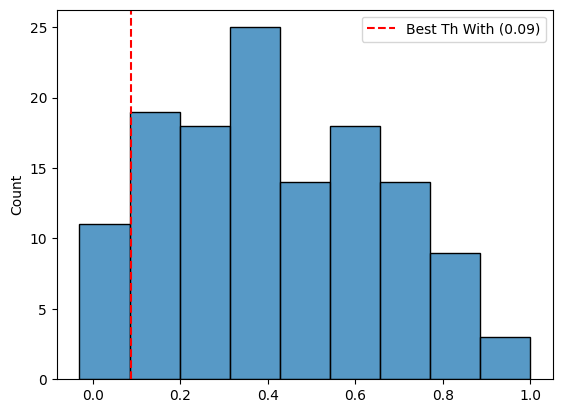

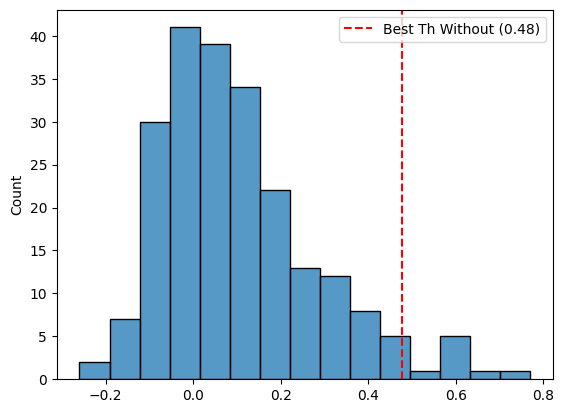

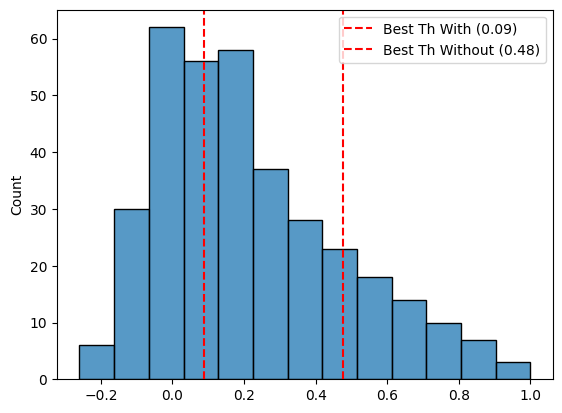

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from IPython.display import display
import random
random.seed(42)
from glob import glob
# Load your data
result_dict = {}






def train_model(X,y):
    results = []
    f1s, accs, precs, recs = [], [], [], []
    # Thresholds to test
    thresholds = np.linspace(min(X), max(X), 100)
    for threshold in thresholds:
        preds = (X >= threshold).astype(int)
        f1s.append(f1_score(y, preds))
        accs.append(accuracy_score(y, preds))
        precs.append(precision_score(y, preds, zero_division=0))
        recs.append(recall_score(y, preds))
        results.append({
            "threshold": threshold,
            "f1": np.mean(f1s),
            "accuracy": np.mean(accs),
            "precision": np.mean(precs),
            "recall": np.mean(recs)
        })
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    # Find the best threshold by F1 (or any other metric)
    best = results_df.loc[results_df["f1"].idxmax()]
    return best["threshold"]

def get_kfcv_results(X,y,label,K=5):
    print(label)
    print(f"Number of True labels in y: {np.sum(y == 1)}")
    print(f"Number of False labels in y: {np.sum(y == 0)}")
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    th_val, f1s_val, accs_val, precs_val, recs_val = [], [], [], [], []
    for train_idx, val_idx in kf.split(X):
        print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}")
        X_train = X[train_idx]
        y_train = y[train_idx]

        best_threshold = train_model(X_train,y_train)
        X_val = X[val_idx]
        y_val = y[val_idx]
        preds = (X_val >= best_threshold).astype(int)
        th_val.append(best_threshold)
        f1s_val.append(f1_score(y_val, preds))
        accs_val.append(accuracy_score(y_val, preds))
        precs_val.append(precision_score(y_val, preds, zero_division=0))
        recs_val.append(recall_score(y_val, preds))
    # Convert results to DataFrame
    results_df = pd.DataFrame({
        "threshold": th_val,
        "f1": f1s_val,
        "accuracy": accs_val,
        "precision": precs_val,
        "recall": recs_val
    })
    
    display(results_df)
    print("Mean Metrics of K fold cross validation of Embedder")
    display(results_df.describe().loc['mean'])
    best_th = results_df.describe().loc['mean']['threshold']
    return best_th



    
for ET in ["Sleep"]:
    print(ET)
    if ET not in result_dict:
        result_dict[ET] = {}
    file_path = glob(f"../exports/groundtruth/Annotated/{ET}*.xlsx")[0]
    print(file_path)
    df = pd.read_excel(file_path)  # or however you load it
    print(df.columns)
    print("Keyword Stats:")
    print(df.is_keyword_present.value_counts())
    
    
    df = df.groupby("UID")[[f"{ET}_similarity", f"gt_{ET}", "is_keyword_present", "Sentence_dictionary","Lemma"]].agg(lambda x: max(x) if len(set(x))>1 else set(x).pop()).reset_index()
    
    print("After Grouping Sentences")
    print(df.is_keyword_present.value_counts())
    df.dropna(subset=f"gt_{ET}",inplace=True)
    print("After removing GT Unknown")
    print(df.is_keyword_present.value_counts())
    print(len(df))
    X = df[f"{ET}_similarity"].values
    y = df[f"gt_{ET}"].values.astype(int)
    y_dict = df.is_keyword_present.values

    print("Metrics of dictionary")
    display({"f1":f1_score(y, y_dict), "acc":accuracy_score(y, y_dict), 
    "prec":precision_score(y, y_dict, zero_division=0), "rec":recall_score(y, y_dict.astype(int))})

    X_all = X.copy()
    y_all = y.copy()
    
    # th_all = train_model(X_all,y_all)
    # preds = (X_all >= th_all).astype(int)
    # print("th",(th_all),"f1",(f1_score(y_all, preds)), "acc",accuracy_score(y_all, preds), "prec",precision_score(y_all, preds, zero_division=0),"rec", recall_score(y_all, preds))
    
    best_th_all = get_kfcv_results(X_all, y_all, label = "*********All********", K=5)
    sentences_by_label = {
        "positive": df.loc[(df[f"gt_{ET}"] == 1) & (df[f"{ET}_similarity"]<best_th_all), "Sentence_dictionary"].tolist(),
        "negative": df.loc[(df[f"gt_{ET}"] == 0) & (df[f"{ET}_similarity"]>=best_th_all), "Sentence_dictionary"].tolist()
        }
    print(sentences_by_label)
    tpr = df.groupby(['is_keyword_present','Lemma'])[f"gt_{ET}"].mean().reset_index()
    keyword_present_tpr = tpr[tpr.is_keyword_present == 1]
    keyword_absent_tpr = tpr[(tpr.is_keyword_present == 0) & (tpr[f"gt_{ET}"]>0)]
    print(keyword_present_tpr, keyword_absent_tpr)
    kw_mask = (df.is_keyword_present == True)
    best_th_with = get_kfcv_results(X_all[kw_mask], y_all[kw_mask], label = "*********With Keyword********", K=3)
    best_th_without = get_kfcv_results(X_all[~kw_mask], y_all[~kw_mask], label = "*********Without Keyword********", K=3)   
    if disagreement_type == "individual":
        disagg_mask = (((X_all < best_th_with) & kw_mask ) | ((X_all>=best_th_without) & (~kw_mask)))
    elif disagreement_type == "together":
        disagg_mask = ((X_all<best_th_with) | (X_all>=best_th_without))
    elif disagreement_type == "anti":
        disagg_mask = ((X_all<best_th_without) | (X_all>=best_th_with))
    
    plt.figure()
    sns.histplot(X_all[kw_mask])
    plt.axvline(x=best_th_with, color='red', linestyle='--', label=f'Best Th With ({best_th_with:.2f})')
    plt.legend()
    plt.figure()
    sns.histplot(X_all[~kw_mask])
    plt.axvline(x=best_th_without, color='red', linestyle='--', label=f'Best Th Without ({best_th_without:.2f})')
    plt.legend()
    plt.figure()
    sns.histplot(X_all)
    plt.axvline(x=best_th_with, color='red', linestyle='--', label=f'Best Th With ({best_th_with:.2f})')
    plt.legend()
    plt.axvline(x=best_th_without, color='red', linestyle='--', label=f'Best Th Without ({best_th_without:.2f})')
    plt.legend()
    
    result_dict[ET]['th_all'] = best_th_all 
    result_dict[ET]['th_with'] = best_th_with
    result_dict[ET]['th_without'] = best_th_without
    result_dict[ET]['disagreement_mask'] = disagg_mask
    result_dict[ET]['disagreement_uid'] = df[disagg_mask]["UID"].tolist()    
    print("proportion of disagreement - dictionary, embedder",result_dict[ET]['disagreement_mask'].mean())    

In [3]:
df.columns

Index(['UID', 'Sleep_similarity', 'gt_Sleep', 'is_keyword_present',
       'Sentence_dictionary', 'Lemma'],
      dtype='object')

(X_all[kw_mask] < best_th_with) | (X_all[~kw_mask]>=best_th_without)

********************Sleep************************
Sleep_132_222_kw_False_phrase_False
 False False Sleep_132_222_kw_False_phrase_False


is_keyword_present
False    221
True     131
Name: count, dtype: int64

file written to ../exports/disagreements/Sleep/all_together_Sleep_132_222_kw_False_phrase_False.xlsx


,technique,pos_sup,neg_sup,f1_score,precision,recall,time
0,dictionary,112,240,0.905,0.840,0.982,0.002
1,LLM_,112,240,0.857,0.832,0.884,4.199
2,LLM__Ki,112,240,0.878,0.856,0.902,4.179
3,LLM__Si,112,240,0.849,0.802,0.902,4.293
4,LLM_KiSi,112,240,0.842,0.789,0.902,4.482


Sleep_132_222_kw_False_phrase_True
Qo False True Sleep_132_222_kw_False_phrase_True


is_keyword_present
False    221
True     131
Name: count, dtype: int64

file written to ../exports/disagreements/Sleep/all_together_Sleep_132_222_kw_False_phrase_True.xlsx


,technique,pos_sup,neg_sup,f1_score,precision,recall,time
0,dictionaryQo,112,240,0.905,0.840,0.982,0.002
1,LLM_Qo,112,240,0.831,0.850,0.812,14.823
2,LLM__KiQo,112,240,0.871,0.842,0.902,10.721
3,LLM__SiQo,112,240,0.849,0.802,0.902,4.380
4,LLM_KiSiQo,112,240,0.842,0.789,0.902,4.490


Sleep_132_222_kw_True_phrase_False
Ko True False Sleep_132_222_kw_True_phrase_False


is_keyword_present
False    221
True     131
Name: count, dtype: int64

file written to ../exports/disagreements/Sleep/all_together_Sleep_132_222_kw_True_phrase_False.xlsx


,technique,pos_sup,neg_sup,f1_score,precision,recall,time
0,dictionaryKo,112,240,0.905,0.840,0.982,0.002
1,LLM_Ko,112,240,0.889,0.824,0.964,12.565
2,LLM__KiKo,112,240,0.877,0.837,0.920,8.106
3,LLM__SiKo,112,240,0.849,0.802,0.902,4.214
4,LLM_KiSiKo,112,240,0.842,0.789,0.902,4.337


Sleep_132_222_kw_True_phrase_True
KoQo True True Sleep_132_222_kw_True_phrase_True


is_keyword_present
False    221
True     131
Name: count, dtype: int64

file written to ../exports/disagreements/Sleep/all_together_Sleep_132_222_kw_True_phrase_True.xlsx


,technique,pos_sup,neg_sup,f1_score,precision,recall,time
0,dictionaryKoQo,112,240,0.905,0.840,0.982,0.002
1,LLM_KoQo,112,240,0.760,0.823,0.705,23.715
2,LLM__KiKoQo,112,240,0.871,0.842,0.902,22.564
3,LLM__SiKoQo,112,240,0.849,0.802,0.902,4.252
4,LLM_KiSiKoQo,112,240,0.842,0.789,0.902,4.318


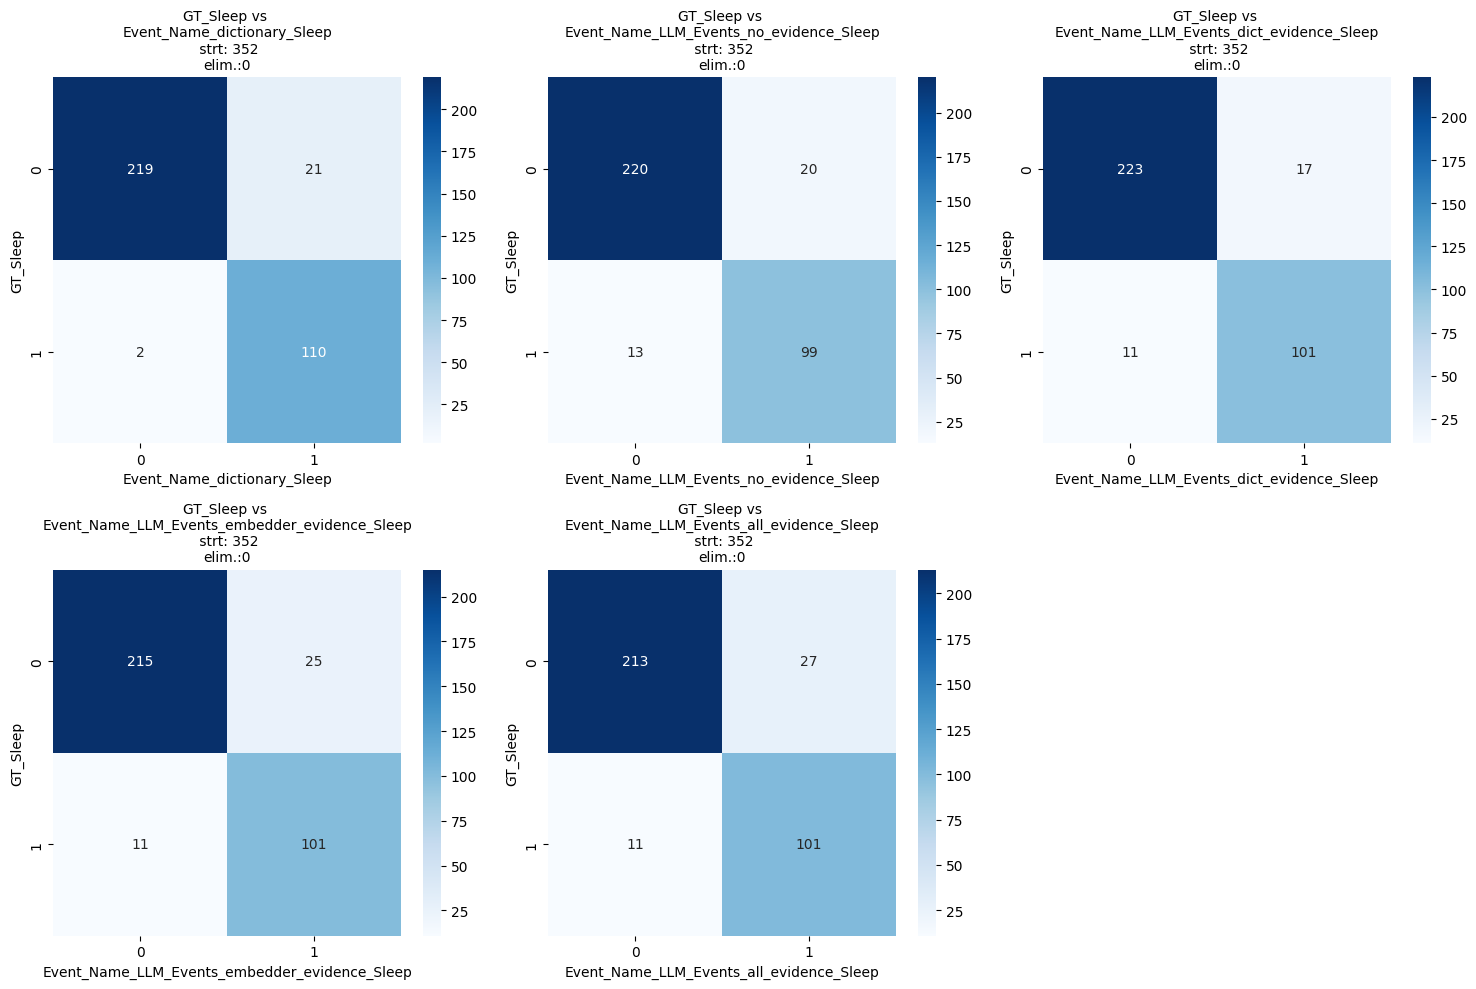

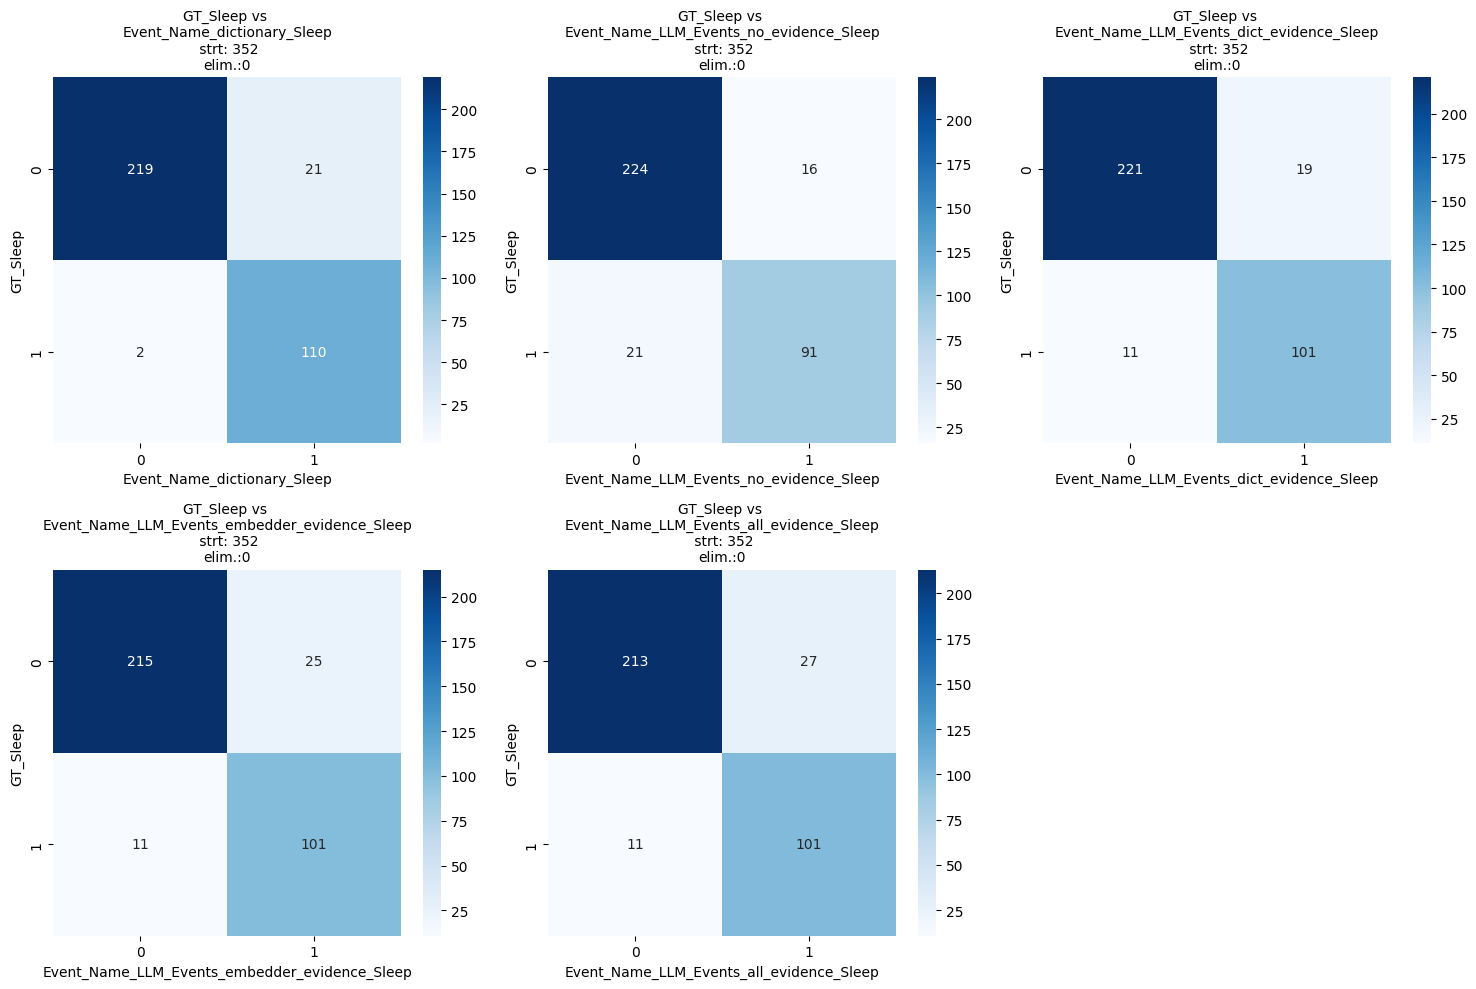

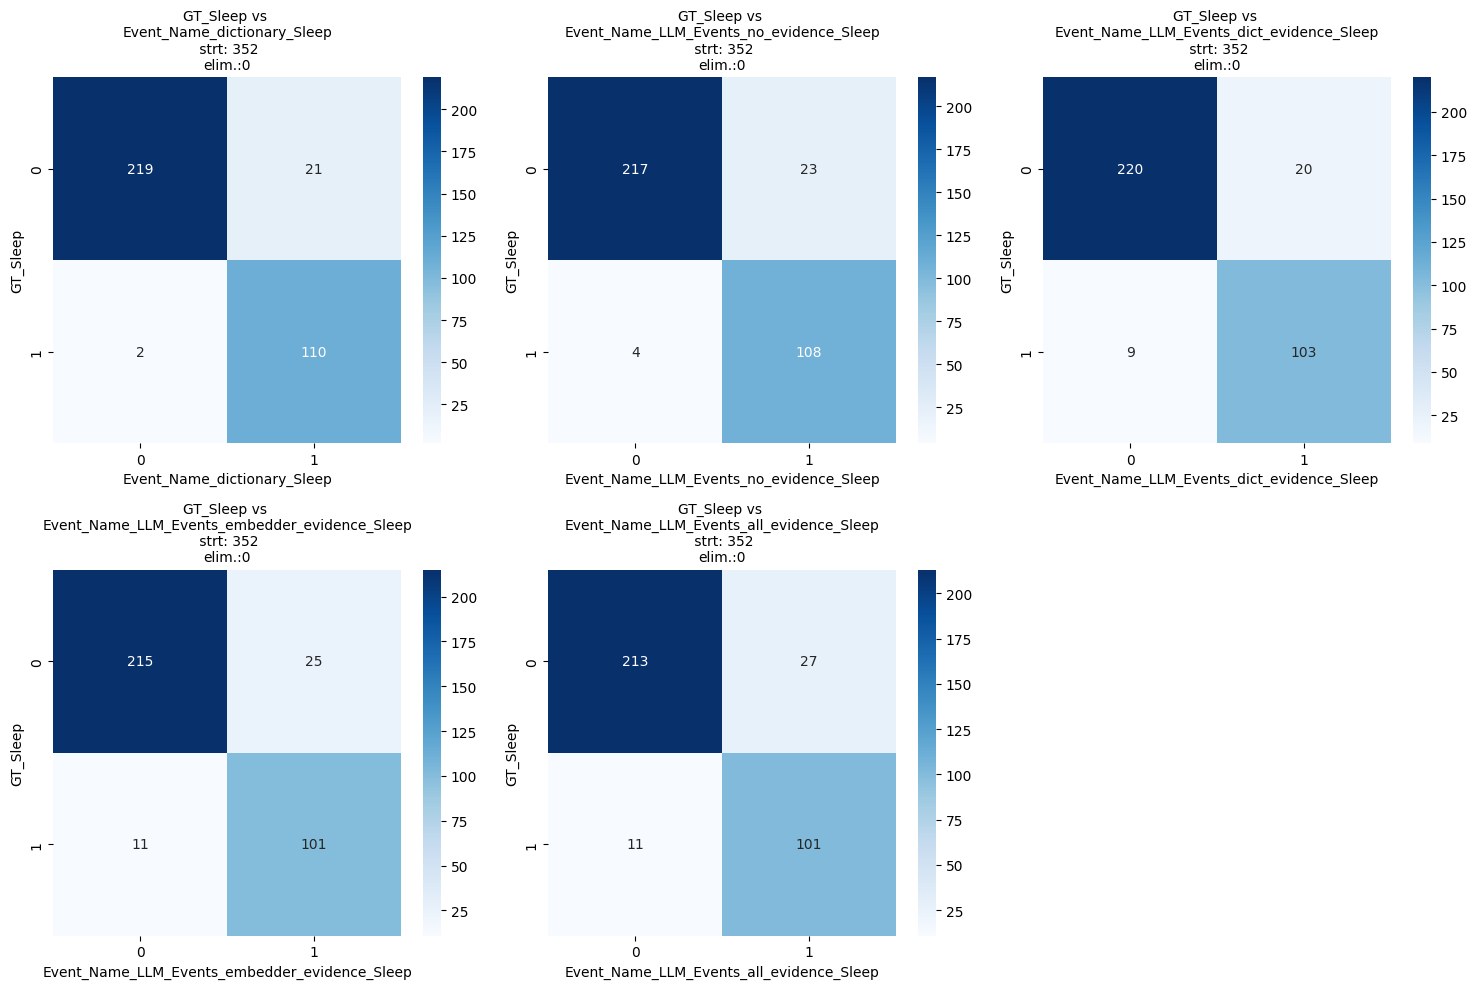

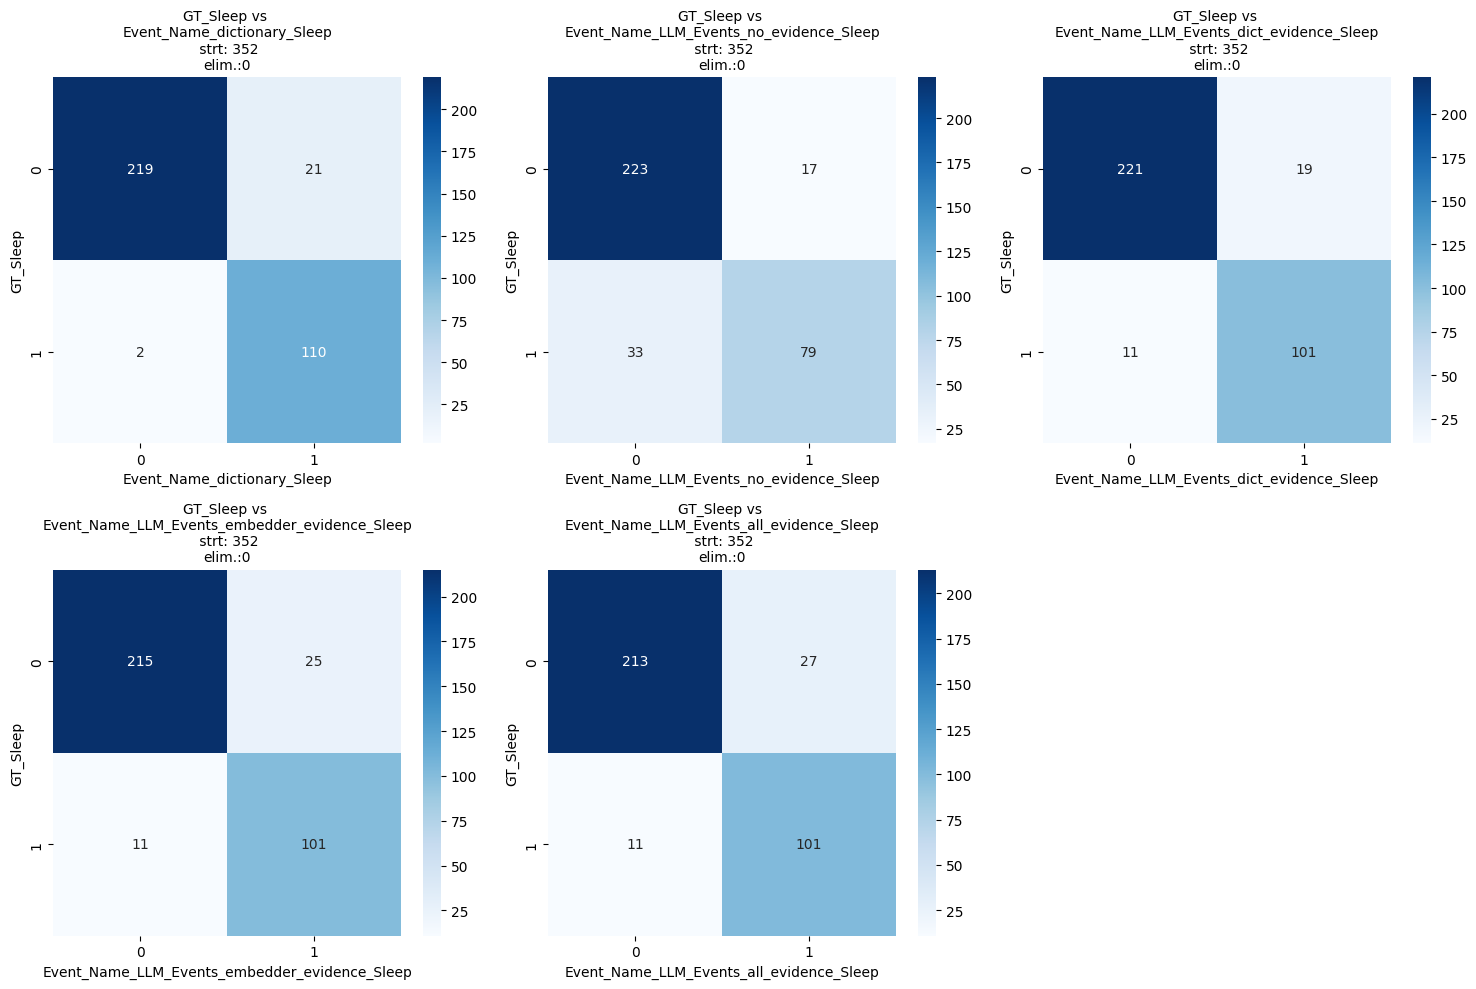

In [4]:
from glob import glob
import os
import pandas as pd
import json
analysis_type = "all"

def get_time(x):
    x = np.array(x)
    # Remove NaNs
    x = x[~np.isnan(x)]
    # If less than 3 values, just return mean
    if len(x) < 3:
        return np.mean(x)
    # Remove outliers using IQR
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    mask = (x >= q1 - 1.5 * iqr) & (x <= q3 + 1.5 * iqr)
    return np.mean(x[mask])

def get_event(x):
    if x["event"] != "Unknown":
        return x["event"]
    x = x.copy()  # avoid modifying original
    try:
        raw = x.get("raw_output", "")
        if isinstance(raw, str):
            parsed = json.loads(raw)
            fields = parsed.keys()
            common_to_labels = set(fields).intersection(set(["Unknown", "Eating", "Sleep", "Excretion", "Family", "Pain"])) 
            if "event_type" in fields:
                x["event"] = parsed.get("event_type")
            elif "event type" in fields:
                x["event"] = parsed.get("event type")
            elif len(common_to_labels) > 0:
                x["event"] = list(common_to_labels)
            else:
                x["event"] = "Unknown"
        else:
            x["event"] = "Unknown"
    except (json.JSONDecodeError, TypeError):
        x["event"] = "Unknown"
    return x["event"]

def fixnames(ls,suffix,remove):
    LS=[]
    for s in ls:
        s = s.replace("_dict_evidence","_Ki").replace("_embedder_evidence","_Si").replace("_no_evidence","").replace("_all_evidence","KiSi").replace("Event_Name_",'').replace("_Events",'_').replace('_'+remove,"")
        LS.append(s+suffix)
    return LS

def get_keyword(x, event_type):
    x = x.copy()  # avoid modifying original
    try:
        raw = x.get("raw_output", "")
        if isinstance(raw, str):
            parsed = json.loads(raw)
            fields = parsed.keys()
            common_to_labels = set(fields).intersection(set(["Unknown", "Eating", "Sleep", "Excretion", "Family", "Pain"])) 
            if "keyword" in fields:
                x["keyword"] = parsed.get("keyword")
                if type(x["keyword"]) == dict:
                    if event_type in x["keyword"]:
                        x["keyword"] = x["keyword"][event_type]
                    else:
                        x["keyword"] = "Unknown"
            elif "keywords" in fields:
                x["keyword"] = parsed.get("keywords")
                if type(x["keyword"]) == dict:
                    if event_type in x["keyword"]:
                        x["keyword"] = x["keyword"][event_type]
                    else:
                        x["keyword"] = "Unknown"
            elif event_type in fields:
                x["keyword"] = parsed.get(event_type)
            else:
                x["keyword"] = "Unknown"
        else:
            x["keyword"] = "Unknown"
    except (json.JSONDecodeError, TypeError):
        x["keyword"] = "Unknown"
    return x["keyword"]

LLM_dict = {}
df_both = pd.read_pickle("../exports/dictionary_biolord_features.pkl")
for ET in ["Sleep"]:
    print(f"********************{ET}************************")
    disag_uid = result_dict[ET]['disagreement_uid']
    llm_files = glob(f"../exports/llm/{ET}/*.pkl")
    gt_file = glob(f"../exports/groundtruth/Annotated/{ET}*.xlsx")[0]
    gt_df = pd.read_excel(gt_file)
    gt_df = gt_df.dropna(subset=f"gt_{ET}")
    llm_models = ['LLM_Events_no_evidence','LLM_Events_dict_evidence','LLM_Events_embedder_evidence','LLM_Events_all_evidence']
    # gt_df = gt_df.groupby("UID")[f"gt_{ET}"].agg(lambda x: max(x)).reset_index()
    gt_df = gt_df.groupby("UID")[[f"{ET}_similarity", f"gt_{ET}", "is_keyword_present", "Sentence_dictionary","Lemma","HADM_ID"]].agg(lambda x: max(x) if len(set(x))>1 else set(x).pop()).reset_index()
    uid_to_gt = {row['UID']:row[f"gt_{ET}"] for _,row in gt_df.iterrows()}
    uid_to_key_present = {row['UID']:row[f"is_keyword_present"] for _,row in gt_df.iterrows()}
    uid_to_lemma = {row['UID']:row[f"Lemma"] for _,row in gt_df.iterrows()}
    uid_to_hadmid = {row['UID']:row[f"HADM_ID"] for _,row in gt_df.iterrows()}
    uid_to_dict_time = {row['UID']:row[f"Time_dictionary"] for _,row in df_both.iterrows()}
    output_folder = f"../exports/disagreements/{ET}"
    os.makedirs(output_folder,exist_ok=True)
    for file in llm_files:
        filename = os.path.basename(file).rstrip('.pkl')
        print(filename)
        _,keyword_requested,_,phrase_requested = filename.split("_")[-4:]
        keyword_requested = eval(keyword_requested)
        # if keyword_requested == False:
        #     print("keyword not requested")
        #     continue
        phrase_requested = eval(phrase_requested)
        suffix = "Ko" if keyword_requested else "" 
        suffix = suffix + ("Qo" if phrase_requested else "")
        
        print(suffix,keyword_requested,phrase_requested,filename)
        
        df = pd.read_pickle(file)
        df[f'dictionary_{ET}_time'] = df["UID"].apply(lambda x:uid_to_dict_time.get(x))
        if analysis_type == "disagreement":
            df = df[df.UID.isin(disag_uid)]
        elif analysis_type =="agreement":
            df = df[~df.UID.isin(disag_uid)]
        elif analysis_type == "all":
            df=df.copy()
        df[f"{ET}_similarity"] = df['Similarity'].apply(lambda x: x[ET])
        df["Keyword_dictionary"] = df["Keyword"]
        df["focus_event"] = ET
        df[f"GT_{ET}"] = df["UID"].apply(lambda x:uid_to_gt.get(x))
        df[f"is_keyword_present"] = df["UID"].apply(lambda x:uid_to_key_present.get(x))
        display(df.is_keyword_present.value_counts())
        df[f"dict_Lemma"] = df["UID"].apply(lambda x:uid_to_lemma.get(x))
        df[f"HADM_ID"] = df["UID"].apply(lambda x:uid_to_lemma.get(x))
        df.dropna(subset=f"GT_{ET}",inplace=True)
        for col in llm_models:
            df[f"Event_Name_{col}"] = df[col].apply(get_event)
            df[f"Keyword_{col}"] = df[col].apply(lambda x:get_keyword(x,ET))
            df[f"{col}_{ET}_time"] = df[col].apply(lambda x:x['event_detection_time'])
        if len(df) > 1:
            first_row = df.iloc[0]
            splittable_columns = ["Event_Name_dictionary",'Event_Name_LLM_Events_no_evidence','Event_Name_LLM_Events_dict_evidence','Event_Name_LLM_Events_embedder_evidence','Event_Name_LLM_Events_all_evidence']
            for model in llm_models:
                if phrase_requested:
                    df[f'Phrase_{model}'] = df[model].apply(lambda x: x['phrase'])
            disagreement_dfs = []
            generated_columns = []

            for col in splittable_columns:
                generated_column = f"{col}_{ET}"
                df[generated_column] = df[col].apply(lambda x: 1 if ET in x else 0)
                
                generated_columns.append(generated_column)
            
            f1s, accs, precs, recs, psup, nsup, times = [],[],[],[],[],[],[]
            y_gt = df[f"GT_{ET}"]
            LLM_dict[(keyword_requested,phrase_requested,f"gt_{ET}")] = y_gt
            for col in generated_columns:
                preds = df[col]
                LLM_dict[(keyword_requested,phrase_requested,col)] = preds
                f1s.append(f1_score(y_gt, preds))
                accs.append(accuracy_score(y_gt, preds))
                precs.append(precision_score(y_gt, preds, zero_division=0))
                recs.append(recall_score(y_gt, preds))   
                psup.append(sum(y_gt))
                nsup.append(sum(y_gt==0))
                times.append(get_time(df[f"{col.lstrip('Event_Name_')}_time"]))
            
            # for col in llm_models:
            #     df[f"Event_Name_{col}_str"] = df[f"Event_Name_{col}"].astype(str)
            #     df[f"Keyword_{col}_str"] = df[f"Keyword_{col}"].astype(str)
            #     print("****keyword present and groundtruth is 1")
            #     display(df[df.is_keyword_present & df[f"GT_{ET}"]][['dict_Lemma',f'Event_Name_{col}_str',f'Keyword_{col}_str',f"GT_{ET}"]].value_counts(dropna=False).reset_index())
            #     print("****keyword present but groundtruth is 0")
            #     display(df[df.is_keyword_present & ~df[f"GT_{ET}"]][['dict_Lemma',f'Event_Name_{col}_str',f'Keyword_{col}_str',f"GT_{ET}"]].value_counts(dropna=False).reset_index())
            #     print("****keyword absent and groundtruth is 1")
            #     display(df[~df.is_keyword_present & df[f"GT_{ET}"]][['dict_Lemma',f'Event_Name_{col}_str',f'Keyword_{col}_str',f"GT_{ET}"]].value_counts(dropna=False).reset_index())
            #     print("****keyword absent but groundtruth is 0")
            #     display(df[~df.is_keyword_present & ~df[f"GT_{ET}"]][['dict_Lemma',f'Event_Name_{col}_str',f'Keyword_{col}_str',f"GT_{ET}"]].value_counts(dropna=False).reset_index())
            
            results_df = {"technique":fixnames(generated_columns,suffix,ET), "pos_sup": psup, "neg_sup": nsup, "f1_score":f1s, "precision":precs, "recall":recs, "time":times} 
            results = pd.DataFrame(results_df)   
            plot_confusion_matrices_for_column_pairs(df, f"GT_{ET}",vis_columns=generated_columns)
            op_path = f"{output_folder}/{analysis_type}_{disagreement_type}_{filename}.xlsx"
            df.to_excel(op_path,index=False)
            print(f"file written to {op_path}")
            display(results)
            



In [ ]:
_,keyword_requested,_,phrase_requested = filename.split("_")[-4:]
keyword_requested, phrase_requested

In [6]:
len(df), df.is_keyword_present.value_counts(), df.GT_Sleep.value_counts()

(352,
 is_keyword_present
 False    221
 True     131
 Name: count, dtype: int64,
 GT_Sleep
 0    240
 1    112
 Name: count, dtype: int64)

In [ ]:
df_both = pd.read_pickle("../exports/dictionary_biolord_features.pkl")
df_both.columns

In [ ]:
df = pd.read_pickle(file)
df["LLM_Events_similarity_evidence"].apply(lambda x:x['event_detection_time']).mean()

In [ ]:
len(df[f"GT_{ET}"]), df[f"GT_{ET}"].value_counts(), 112/(112+240)

In [ ]:
LLM_dict.keys()

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import accuracy_score
ET = "Excretion"
# list_models = [(False, False, 'gt_Sleep'), (False, False, 'Event_Name_dictionary_Sleep'), (False, False, 'Event_Name_LLM_Events_no_evidence_Sleep'), (False, False, 'Event_Name_LLM_Events_dict_evidence_Sleep'), (False, False, 'Event_Name_LLM_Events_embedder_evidence_Sleep'), (False, False, 'Event_Name_LLM_Events_all_evidence_Sleep'), (False, True, 'gt_Sleep'), (False, True, 'Event_Name_dictionary_Sleep'), (False, True, 'Event_Name_LLM_Events_no_evidence_Sleep'), (False, True, 'Event_Name_LLM_Events_dict_evidence_Sleep'), (False, True, 'Event_Name_LLM_Events_embedder_evidence_Sleep'), (False, True, 'Event_Name_LLM_Events_all_evidence_Sleep'), (True, False, 'gt_Sleep'), (True, False, 'Event_Name_dictionary_Sleep'), (True, False, 'Event_Name_LLM_Events_no_evidence_Sleep'), (True, False, 'Event_Name_LLM_Events_dict_evidence_Sleep'), (True, False, 'Event_Name_LLM_Events_embedder_evidence_Sleep'), (True, False, 'Event_Name_LLM_Events_all_evidence_Sleep'), (True, True, 'gt_Sleep'), (True, True, 'Event_Name_dictionary_Sleep'), (True, True, 'Event_Name_LLM_Events_no_evidence_Sleep'), (True, True, 'Event_Name_LLM_Events_dict_evidence_Sleep'), (True, True, 'Event_Name_LLM_Events_embedder_evidence_Sleep'), (True, True, 'Event_Name_LLM_Events_all_evidence_Sleep')]
list_models = [(False, False, f'gt_{ET}'), (False, False, f'Event_Name_dictionary_{ET}'), 
               (False, False, f'Event_Name_LLM_Events_no_evidence_{ET}'), (False, False, f'Event_Name_LLM_Events_dict_evidence_{ET}'), 
               (True, False, f'Event_Name_LLM_Events_no_evidence_{ET}'), 
               ]

for i in range(len(list_models)):
    for j in range(i + 1, len(list_models)):
        model_A = list_models[i]
        model_B = list_models[j]
        y_true = LLM_dict[(False, False, f'gt_{ET}')]
        y_pred_A = LLM_dict[model_A]
        y_pred_B = LLM_dict[model_B]



        correct_A = [a == t for a, t in zip(y_pred_A, y_true)]
        correct_B = [b == t for b, t in zip(y_pred_B, y_true)]

        b = sum((a == 1 and b == 0) for a, b in zip(correct_A, correct_B))
        c = sum((a == 0 and b == 1) for a, b in zip(correct_A, correct_B))

        table = [[0, b],
                 [c, 0]]

        result = mcnemar(table, exact=True)
        print(f"\nComparing {model_A} vs {model_B}: \n   Contigency Table: {table} \n   p-value = {result.pvalue}")

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    matthews_corrcoef
)

y_true = LLM_dict[(False, False, f'gt_{ET}')]

for model in list_models:
    y_pred = LLM_dict[model]
    
    # Precision, Recall, F1 for positive class (label 1)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    mcc= matthews_corrcoef(y_true, y_pred)
    
    # PR-AUC (if predictions are binary, average_precision_score still works)
    pr_auc = average_precision_score(y_true, y_pred)

    print(f"Model: {model}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1 Score:  {f1:.4f}")
    print(f"   PR-AUC:    {pr_auc:.4f}")
    print(f"   MCC:    {mcc:.4f}")
    print("-" * 40)

results = []

for model in list_models:
    y_pred = LLM_dict[model]
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    pr_auc = average_precision_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    results.append((model, precision, recall, f1, pr_auc, mcc))

# Sort by F1 or PR-AUC
sorted_results = sorted(results, key=lambda x: x[5], reverse=True)  # sort by F1

for model, prec, rec, f1, pr, mcc in sorted_results:
    print(f"{model} -> Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, PR-AUC: {pr:.3f}, MCC: {mcc:.3f}")


In [ ]:
len(y_true), y_true.mean(), set(y_true), len(y_pred_A), y_pred_A.mean(), len(y_pred_B), y_pred_B.mean(), 

In [ ]:
df[[i for i in splittable_columns]]

In [ ]:
len(df), len(gt_df)

In [ ]:
ET="Sleep"
gt_df = pd.read_excel(f"/home/asusaiyah/data/tactics_storage/projects/event_log_from_text/exports/groundtruth/Annotated/{ET}_155_233.xlsx")
df_both = pd.read_pickle("../exports/dictionary_biolord_features.pkl")

In [ ]:

event_types = ["Pain", "Sleep", "Excretion", "Eating", "Family"]
vis_columns = ['Event_Name_dictionary','Event_Name_LLM_Events_no_evidence','Event_Name_LLM_Events_dict_evidence','Event_Name_LLM_Events_embedder_evidence','Event_Name_LLM_Events_all_evidence']

splittable_columns = ["Event_Name_dictionary",'Event_Name_LLM_Events_no_evidence','Event_Name_LLM_Events_dict_evidence','Event_Name_LLM_Events_embedder_evidence','Event_Name_LLM_Events_all_evidence']
disagreement_dfs = []
generated_columns = []
for file_name in ["only_event_mention","no_particular_event_mention"]:
    disagreement_df = pd.read_pickle(f"../exports/disagreements/{file_name}.pkl")
    
    if file_name == "only_event_mention":
        disagreement_type = "keyword present but embedder low"
        disagreement_df['disagreement_type'] = disagreement_type
        disagreement_df['present/absent_keyword_type'] = disagreement_df["Event_Name_dictionary"].apply(lambda x: set(x).pop())
    elif file_name == "no_particular_event_mention":
        disagreement_type = "keyword absent but embedder high"
        disagreement_df['disagreement_type'] = disagreement_type
        disagreement_df['present/absent_keyword_type'] = disagreement_df.apply(lambda row: [i for i in event_types if (i not in row['Event_Name_dictionary'] and row['Similarity'][i]>=0.2)], axis=1)
    if len(disagreement_df)<=1:
        continue
    print(file_name)
    for col in vis_columns:
        disagreement_df[col] = disagreement_df[col].apply(lambda x: "_".join(tuple(set(x))) if type(x)==list else x)
        disagreement_df[f"{col}_multi"] = disagreement_df[col].apply(lambda x: {i: x.count(i) if isinstance(x, list) else 0 for i in event_types})
        print(disagreement_df[f"{col}_multi"])
    for event_type in event_types:
        for col in splittable_columns:
            generated_column = f"{col}_{event_type}"
            disagreement_df[generated_column] = disagreement_df[col].apply(lambda x: 1 if event_type in x else 0)
            generated_columns.append(generated_column)
    disagreement_df['Similarity'] = disagreement_df['Similarity'].apply(lambda x: {k:f"{v:0.2f}" for k,v in x.items()})
    disagreement_df.to_excel(f"../exports/disagreements/{file_name}.xlsx")
    disagreement_dfs.append(disagreement_df)
    # Store results in a DataFrame
    # cohenskappa_results_df = get_cohens_kappa(disagreement_df,vis_columns, remove_multi=True)
    # cohenskappa_results_df.to_excel(f"../exports/disagreements/{file_name}_cohenskappa.xlsx")
    
    # chisquare_results_df = get_chisquare(disagreement_df,vis_columns)
    # chisquare_results_df.to_excel(f"../exports/disagreements/{file_name}_chisquare.xlsx")
    
    # plot_confusion_matrices_for_column_pairs(disagreement_df,vis_columns).savefig(f"../exports/disagreements/{file_name}_cms.png")
DISAGREEMENT_DF = pd.concat(disagreement_dfs, ignore_index=True)
DISAGREEMENT_DF.Keyword = DISAGREEMENT_DF.Keyword.apply(lambda x: tuple(x))
DISAGREEMENT_DF = DISAGREEMENT_DF.drop_duplicates(subset=['ROW_ID', 'Sent_ID','Keyword', 'Sentence_dictionary','disagreement_type'])
DISAGREEMENT_DF=DISAGREEMENT_DF.explode('present/absent_keyword_type')
keep_columns = ['ROW_ID', 'Sent_ID','Keyword', 'Sentence_dictionary','present/absent_keyword_type','disagreement_type','Event_Name_dictionary',"Similarity"] + generated_columns
DISAGREEMENT_DF[keep_columns].to_excel(f"../exports/disagreements/all_disagreements.xlsx",index=False)


In [ ]:
DISAGREEMENT_DF[DISAGREEMENT_DF.Similarity.apply(lambda x: True if any([v=="0.20" for v in x.values()]) else False)]['disagreement_type'].value_counts()

In [9]:
ET = "Sleep"
dtype = "disagreement"
dfs = pd.read_excel(glob(f"../exports/disagreements/{ET}/{dtype}_together_{ET}_*_kw_False_phrase_False.xlsx")[0])
dfgs = dfs.groupby(["is_keyword_present",f"GT_{ET}",f"Event_Name_LLM_Events_no_evidence_{ET}",f"Event_Name_LLM_Events_dict_evidence_{ET}"])['Sentence_dictionary'].agg(lambda x:list(x)).reset_index()
dfgs['count'] = dfgs.Sentence_dictionary.apply(len)
dfgs.to_excel(f"../exports/paper/{ET}_{dtype}_llm_basic.xlsx")

dft = pd.read_excel(glob(f"../exports/disagreements/{ET}/{dtype}_together_{ET}_*_kw_True_phrase_False.xlsx")[0])
dft['base_llm_no_evidence'] = dfs[f'Event_Name_LLM_Events_no_evidence_{ET}']
dfgt = dft.groupby(["is_keyword_present",f"GT_{ET}","base_llm_no_evidence",f"Event_Name_LLM_Events_no_evidence_{ET}"])[['Sentence_dictionary','Keyword_LLM_Events_no_evidence']].agg(lambda x:list(x)).reset_index()
dfgt['count'] = dfgt.Sentence_dictionary.apply(len)
dfgt.to_excel(f"../exports/paper/{ET}_{dtype}_llm_basic_evidence.xlsx")

In [10]:
from typing import Counter
import pandas as pd
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk

def get_lemma_data():
    with open("../resources/lemma.en.txt", "r", encoding="utf-8") as file:
        lines = file.readlines()
    lemma_data = []
    for line in lines:
        lemma_part, forms_part = line.strip().split(" -> ")
        lemma = lemma_part.split("/")[0]  # Remove frequency
        all_forms = forms_part.split(",") + [lemma]
        lemma_data.append({"lemma": lemma, "all_forms": all_forms})
    lemma_data = pd.DataFrame(lemma_data)
    return lemma_data

# Download required resources (only needed once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')  # for lemmatizer to work well

lemma_data = get_lemma_data()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import nltk
from nltk.corpus import stopwords

# Download stopwords list (only once)
nltk.download('stopwords')

# Get English stop words set for fast lookup
stop_words = set(stopwords.words('english'))


def unravel(x):
    if "{" in x: 
        x= eval(x).values()  
        if type(x) == tuple and type(x[0]) == dict:
            x[0] = x[0].values()
    return x

def get_word_counts(x):
    x = str(list(x) if type(x)!=str else x)
    x = ''.join([ch for ch in x if ch.isalpha() or ch == ',' or ch.isspace()])
    x = x.replace(',','')
    x = x.replace('Unknown','')
    return x


def get_lemma(token):
    global lemma_data
    searched_lemma = lemma_data[lemma_data["all_forms"].apply(lambda x: token in x)]['lemma']
    if len(searched_lemma) > 0:
        return searched_lemma.iloc[0]
    else:
        return token


def value_count_words(x, n=2):
    global lemma_data
    ngrams = []

    for sentence in x:
        if isinstance(sentence, str):
            tokens = word_tokenize(sentence.lower())
            lemmas = [get_lemma(token) for token in tokens]
            
            # Build n-grams
            if len(lemmas) >= n:
                ngram_tuples = zip(*[lemmas[i:] for i in range(n)])
                ngram_strings = [' '.join(gram) for gram in ngram_tuples]
                ngrams.extend(ngram_strings)

    return Counter(ngrams)


dft['keyword_best_llm'] = dft["Keyword_LLM_Events_no_evidence"].apply(lambda x: unravel(x))
df_sel2 = dft[dft[f"Event_Name_LLM_Events_no_evidence_{ET}"]==1]
val_c_1 = value_count_words(df_sel2['keyword_best_llm'].apply(get_word_counts).tolist(),1)
val_c_1 = {k: v for k, v in sorted(val_c_1.items(), key=lambda item: item[1], reverse=True) if k.lower() not in stop_words}
dictionary = pd.read_excel("../resources/keyword_dict_annotated_expanded.xlsx")
val_c_1 = {k:v for (k,v) in val_c_1.items() if k not in dictionary['form'].tolist()}
val_c_2 = value_count_words(df_sel2['keyword_best_llm'].apply(get_word_counts).tolist(),2)
val_c_2 = {k: v for k, v in sorted(val_c_2.items(), key=lambda item: item[1], reverse=True) if k.lower() not in stop_words}
dictionary = pd.read_excel("../resources/keyword_dict_annotated_expanded.xlsx")
val_c_2 = {k:v for (k,v) in val_c_2.items() if all([jk not in dictionary['form'].tolist() for jk in k.split(' ')]) and not any([i in stop_words for i in k.split(' ')])}
print(val_c_1)
print(val_c_2)





[nltk_data] Downloading package punkt to /home/asusaiyah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/asusaiyah/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/asusaiyah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/asusaiyah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asusaiyah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'night': 5, 'rest': 2, 'bed': 2, 'sleepy': 2, 'fall': 2, 'overnight': 2, 'none': 1, 'comfortable': 1, 'onoff': 1, 'sleepliness': 1, 'doze': 1, 'calm': 1, 'lethargic': 1, 'throughout': 1, 'shift': 1, 'back': 1, 'wake': 1, 'easily': 1, 'noc': 1, 'supplement': 1, 'short': 1, 'patient': 1, 'quality': 1, 'quantity': 1, 'describe': 1}
{'throughout shift': 1, 'wake easily': 1}


In [ ]:
dft.Event_Name_LLM_Events_no_evidence_Sleep

In [ ]:
for i,sen in enumerate(['2mg ivp given as well as percocet for c/o of r fem leg discomfort and ambien for sleep/anxiety and settled back to sleep with gradual relief of discomfort/sob within 10min', 'back/rib pain relieved with pro re nata fentanyl - resting comfortably - slept on/off', "gi tolerating solid foods fruit/soup at lunch time.. plan to hold on 2nd dose of enlapril d/t diastolic blood pressure 120's while sleeping", "patient in nsr with bp 130-150 (while asleep). bp as high as 170's while awake/talking", 'percocets started w improved relief,able to sleep in naps', "problem is when patient falls asleep & doesn't bolus himself--pain tends to get ahead of him. ??", "resp--ls coarse/bronchial in bilat upper lobes, crackles 1/2 up bilat bases, no c/o sob, on ra sat down to 90%, o2 4l on w/sat up to 98% and down to 92-93% while sleeping, patient w/non prod, non congested cough, able to talk in full sentences w/out any c/o sob, rr 20-24, non labored, patient given 40mg iv lasix for crackles/decreased sat and decreased u/o w/lg diuresis, u/o has con't ~40cc/heart rate during noc", 'with time recognized family, after waking from a short nap saw one of her daughters and smiled and said clearly "hi sweetie"']):
    print(i+1, f'"{sen}"')